In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [2]:
# Load datasets
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [3]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokens = tokenizer(
    train_df['text'].astype(str).tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
labels = torch.tensor(train_df['target'].tolist())

# Split data
input_ids_train, input_ids_val, attention_train, attention_val, y_train, y_val = train_test_split(
    tokens['input_ids'], tokens['attention_mask'], labels, test_size=0.2, random_state=42
)


In [5]:
# Create DataLoaders
batch_size = 16
train_data = TensorDataset(input_ids_train, attention_train, y_train)
val_data = TensorDataset(input_ids_val, attention_val, y_val)

train_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
val_loader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)


In [6]:
# Define BERT + LSTM model
class BERT_LSTM(nn.Module):
    def __init__(self):
        super(BERT_LSTM, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm = nn.LSTM(768, 128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128*2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Freeze BERT
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        lstm_out, _ = self.lstm(outputs.last_hidden_state)
        out = self.fc(lstm_out[:, -1, :])
        return self.sigmoid(out)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERT_LSTM().to(device)

# Training
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
train_losses, val_losses = [], []
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels.float())
            total_loss += loss.item()
    val_losses.append(total_loss / len(val_loader))

In [9]:
# Evaluation
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask).squeeze()
        preds = (outputs > 0.5).int().cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       874
           1       0.81      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523



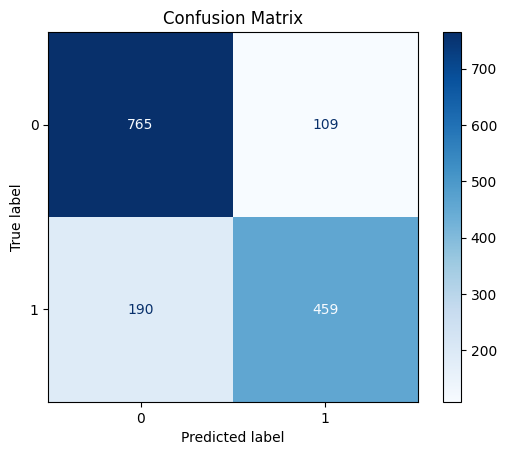

In [10]:
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [11]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nValidation Accuracy: {accuracy * 100:.2f}%")


Validation Accuracy: 80.37%


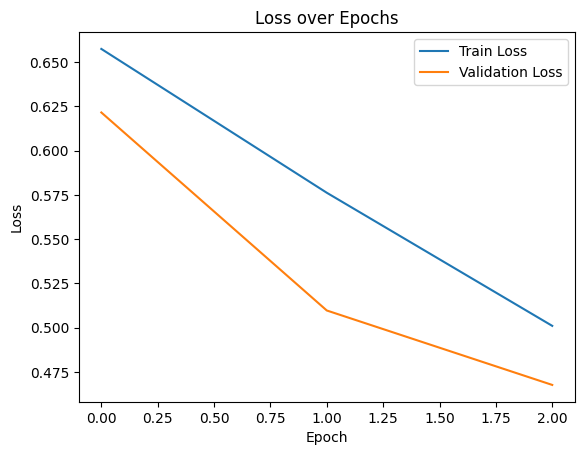

In [12]:
# Plot loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Z-test and T-test
accuracy_array = np.array(y_pred) == np.array(y_true)
val_accuracy = accuracy_array.mean()
z_score = (val_accuracy - 0.5) / np.sqrt((0.5 * (1 - 0.5)) / len(y_true))
_, p_value_z = stats.norm.cdf(z_score), 1 - stats.norm.cdf(abs(z_score))

t_stat, p_value_t = stats.ttest_1samp(accuracy_array.astype(int), 0.5)

print(f"\nZ-test: Z = {z_score:.3f}, p = {p_value_z:.4f}")
print(f"T-test: t = {t_stat:.3f}, p = {p_value_t:.4f}")

# Final Decision
if p_value_z < 0.05 and p_value_t < 0.05:
    print("\n The model is statistically significant. We ACCEPT the model.")
else:
    print("\nThe model is NOT statistically significant. We REJECT the model.")


Z-test: Z = 23.702, p = 0.0000
T-test: t = 29.826, p = 0.0000

 The model is statistically significant. We ACCEPT the model.
